In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from pathlib import Path
import zipfile
import cv2 as cv
from sklearn.cluster import KMeans


In [3]:
dfs = [[] for _ in range(10)]
for i in range(10):
    for k in range(100):
        df = pd.read_csv(f"training_data/stroke_{i}_{k+1:04}.csv", header=None)
        df.drop(df.columns[2], axis=1, inplace=True)
        # df = (df - df.min()) / (df.max()-df.min())
        df = (df - df.mean()) / (df.std())
        dfs[i].append(df)


In [4]:
LINE_BINS = 16
ANGLE_BINS = 16
BINS = LINE_BINS + ANGLE_BINS
def featurize_angle(df: pd.DataFrame):
    features = []
    for i in range(df.shape[0]-1):
        features.append(np.arctan2(df.iloc[i, 1], df.iloc[i, 0]))

    res = np.histogram(features, bins=ANGLE_BINS, range=(-np.pi, np.pi))[0]
    res = res / res.sum()
    return res

def featurize(df: pd.DataFrame):
    features = []
    ref = np.array((0,1))
    
    for i in range(df.shape[0]-1):
        dir = df.iloc[i+1] - df.iloc[i]
        norm = np.linalg.norm(dir)
        if norm == 0:
            continue
        # angle = np.arccos(np.dot(dir, ref) / norm)
        angle = np.dot(dir, ref) / norm
        features.append(angle)
    res = np.histogram(features, bins=LINE_BINS, range=(-1, 1))[0]
    res = res / res.sum()

    anglefeatures = featurize_angle(df)
    res = np.concatenate((res, anglefeatures))
    return res


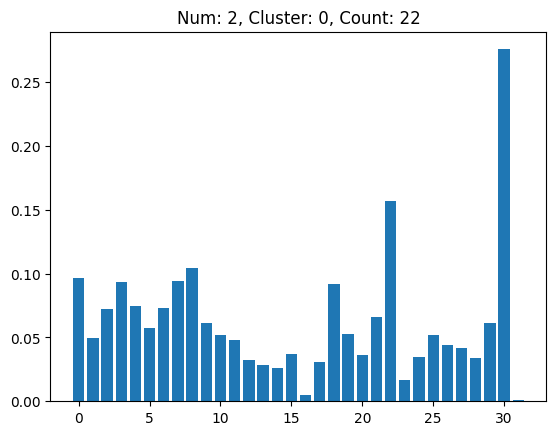

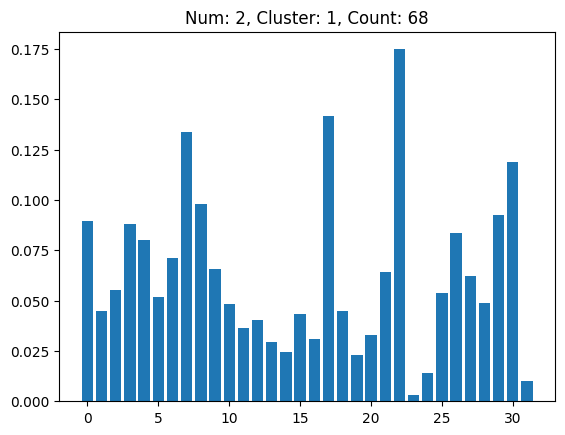

In [5]:
test = []
num = 2
features = []
for k in range(90):
    features.append(featurize(dfs[num][k]))

clustercount = 2
km = KMeans(n_clusters=clustercount, n_init=10)
km.fit(features)
for i in range(clustercount):
    plt.bar(range(BINS), km.cluster_centers_[i])
    plt.title(f"Num: {num}, Cluster: {i}, Count: {np.count_nonzero(km.labels_ == i)}")
    plt.show()

width = 0.3       

# Plotting
# plt.bar(range(BINS), km.cluster_centers_[0] , width, label=f'Count: {np.count_nonzero(km.labels_ == 0)}')
# plt.bar(np.array(range(BINS)) + width, km.cluster_centers_[1], width, label=f'Count: {np.count_nonzero(km.labels_ == 1)}')
# plt.show()
# avg = features/90
# test.append(avg)
# plt.bar(range(BINS), avg)
# plt.title(str(num))
# plt.show()


In [6]:
fvs = []
clustercount = 1


for num in range(10):
    features = []
    for k in range(90):
        features.append(featurize(dfs[num][k]))

    km = KMeans(n_clusters=clustercount, n_init=10)
    km.fit(features)
    fvs += km.cluster_centers_.tolist()
    # fvs.append(km.cluster_centers_[0])
    # fvs.append(km.cluster_centers_[1])
    # plt.bar(range(BINS), avg)
    # plt.title(str(num))
    # plt.show()



In [7]:
from scipy.stats import chisquare
from scipy.special import kl_div
correct = 0
incorrect = 0

for num in range(10):
    nc = 0
    ni = 0
    for i in range(90, 100):
        df = dfs[num][i]
        tmp = featurize(df)

        scores = []
        for ti, template in enumerate(fvs):
            # score = chisquare(tmp, template)
            score = np.sum(kl_div(tmp, template))
            # scores.append(score.pvalue)
            scores.append(score)

        selected = np.argmin(scores)//clustercount
        # selected = np.argmax(scores)//2
        # print(f"i: {i}, Num: {num}, Estimate: {selected}")

        if selected == num:
            correct += 1
            nc += 1
        else:
            incorrect += 1
            ni += 1

    print(f"Num: {num}, Correct: {nc}, Incorrect: {ni}, Accuracy: {nc/(nc+ni)}")
print(f"Correct: {correct}, Incorrect: {incorrect}, Accuracy: {correct/(correct+incorrect)}")


Num: 0, Correct: 8, Incorrect: 2, Accuracy: 0.8
Num: 1, Correct: 6, Incorrect: 4, Accuracy: 0.6
Num: 2, Correct: 10, Incorrect: 0, Accuracy: 1.0
Num: 3, Correct: 10, Incorrect: 0, Accuracy: 1.0
Num: 4, Correct: 6, Incorrect: 4, Accuracy: 0.6
Num: 5, Correct: 8, Incorrect: 2, Accuracy: 0.8
Num: 6, Correct: 9, Incorrect: 1, Accuracy: 0.9
Num: 7, Correct: 9, Incorrect: 1, Accuracy: 0.9
Num: 8, Correct: 8, Incorrect: 2, Accuracy: 0.8
Num: 9, Correct: 8, Incorrect: 2, Accuracy: 0.8
Correct: 82, Incorrect: 18, Accuracy: 0.82


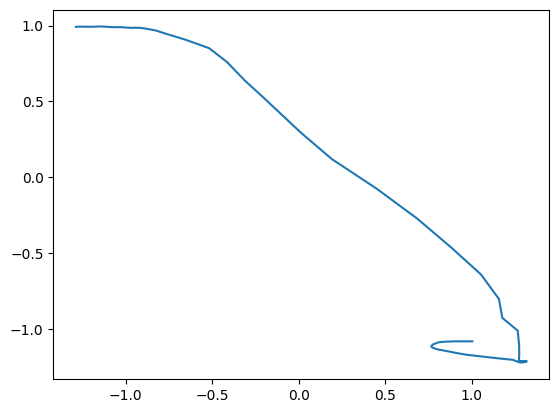

In [8]:
num = 1
i = 90
plt.plot(dfs[num][i].iloc[:,0], dfs[num][i].iloc[:,1])
